# Introduction

* Problem description (Running out of antibiotics, spread of resistant strains, show world map)
* Research description (Building a sexual network contact model for Amsterdam, new antibiotic is available within years and it is necessary to come up with a management plan to prevent development of new resistant strains)
* In two weeks, not possible to come up with a fully realistic model of Amsterdam but we could do the following:
    * Paper of mathematical model
        * In this model it is found that treatment rate has more effect than number of sexual partners, as opposed to previous literature suggests
    * Simple network model
    * Advanced stochastic network model
* Add something about sexual contact network article


# Mathematical model of antibiotic resistance N. gonorrhoeae spread

### Transmission model
* $Sen$ and $Res$ indicate the antibitotic-sensitive and -resistand N. gonorrhoeae strains
* $G = \{L,H\}$ is the set of low and high sexual activity groups, $i \in G$
* Each sexual activity group $N_i$ consists of:
    * susceptible hosts $S_i$
    * hosts infected with an antibiotic-sensitive strain, $I_{Sen_i}$
    * hosts infected with an antibiotic-resistant strain, $I_{Res_i}$
* Hosts are redistributed to either the same of the other sexual activity group at rate $\gamma$
* Hosts leave or enter the population at rate $\alpha$
* Susceptible hosts become infected depending on:
    * the partner change rate, $\pi_i$
    * the transmission probability per partnership, $\beta_{ij}$
    * the sexual mixing matrix $\rho_{ij}$ 
* Hosts infected with an antibiotic-sensitive strain can:
    * recover spontaneously at rate $\nu$
    * receive treatment at rate $\tau$
* Hosts receiving treatment recover at rate $\tau(1 - \mu)$
* Hosts decelop resistance during treatment with probability $\mu$
* Host infected with an antibiotic-resistance strain can only recover spontaneously at rate $\nu$
    
The sexual mixing matrix describes how many partnerships are formed within and outside the host's activity group:

$$ \rho_{ij} = \epsilon \delta_{ij} + (1 - \epsilon) \frac{\pi_j N_j}{\sum_{k \in G} \pi_k N_k} $$

Here, $\delta_{ij} = 1$ if $i = j$ and 0 otherwise. Model parameters were estimated from sexual behavior data, calibrated trough model simulation or informed by literature. The parameters can be found on page 5 of the article

In [2]:
## imports for the math model
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
from math_model_functions import *

## imports for the network model
import networkx as nx
from networkx.utils.random_sequence import (powerlaw_sequence)
from numba import jit
from network_model import *

## imports for the stochastic network model
from stochastic_network_model import *
import matplotlib.lines as mlines

from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='jshtml')
# import networkx.utils.create_degree_sequence as create_degree_sequence
%matplotlib notebook
# TODO: Change resolution of animation

### MSM Parameters
Parameters for the "Men having sex with men group"

In [3]:
Nh = 5.3e-2
N = np.array([1 - Nh, Nh])

S = np.array([N[0]*0.995,N[1]*0.90])
Ires = np.array([0, 0])
Isen = np.array([N[0]*0.005, N[1]*0.1])

pi = np.array([0.41, 30.49])


BLL = np.array([0.42,0.59,0.77])
BHH = np.array([0.25,0.30,0.40])
alpha = 1 / 29


gamma = 1
epsilon = np.array([0.30,0.57,0.80])
phi = np.array([0.48,0.64,0.81])
mu = 1e-3
D = np.array([0.14,0.19,0.25])

y0 = np.concatenate((S, Ires, Isen))
# y0 /= np.sum(y0)
t = np.arange(0,30,0.001)
sol_msm = []
for i in range(3):
    beta = np.array([[BLL[i], 1], [1, BHH[i]]])
    beta[0, 1] = beta[1, 0] = np.sqrt(beta[0, 0] * beta[1, 1])
    sol_msm.append(odeint(math_model, y0, t, args=(N, pi, alpha, beta, gamma, epsilon[i], phi[i], mu, D[i])))
    
sol_msm = np.array(sol_msm)

### HMW Parameters
Parameters for the heterosexual men

In [4]:
Nh = 6.3e-2
N = np.array([1 - Nh, Nh])

S = np.array([N[0]*0.995,N[1]*0.90])
Ires = np.array([0, 0])
Isen = np.array([N[0]*0.005, N[1]*0.1])

pi = np.array([0.25, 4.57])


alpha = 1 / 29
BLL = np.array([0.79,0.87,0.94])
BHH = np.array([0.63,0.72,0.81])

gamma = 1
epsilon = np.array([0.53,0.73,0.89])
phi = np.array([0.36,0.50,0.66])
mu = 1e-3
D = np.array([0.46,0.55,0.66])

y0 = np.concatenate((S, Ires, Isen))
# y0 /= np.sum(y0)
t = np.arange(0,30,0.001)
sol_hmw = []
for i in range(3):
    beta = np.array([[BLL[i], 1], [1, BHH[i]]])
    beta[0, 1] = beta[1, 0] = np.sqrt(beta[0, 0] * beta[1, 1])
    sol_hmw.append(odeint(math_model, y0, t, args=(N, pi, alpha, beta, gamma, epsilon[i], phi[i], mu, D[i])))
    
sol_hmw = np.array(sol_hmw)

### Figures and plots

<IPython.core.display.Javascript object>


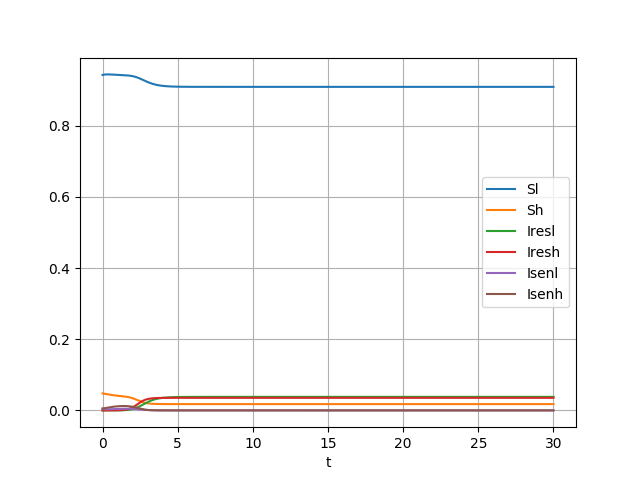

In [5]:
plt.figure()
plt.plot(t, sol_msm[1,:, 0], label='Sl')
plt.plot(t, sol_msm[1,:, 1], label='Sh')
plt.plot(t, sol_msm[1,:, 2], label='Iresl')
plt.plot(t, sol_msm[1,:, 3], label='Iresh')
plt.plot(t, sol_msm[1,:, 4], label='Isenl')
plt.plot(t, sol_msm[1,:, 5], label='Isenh')

plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


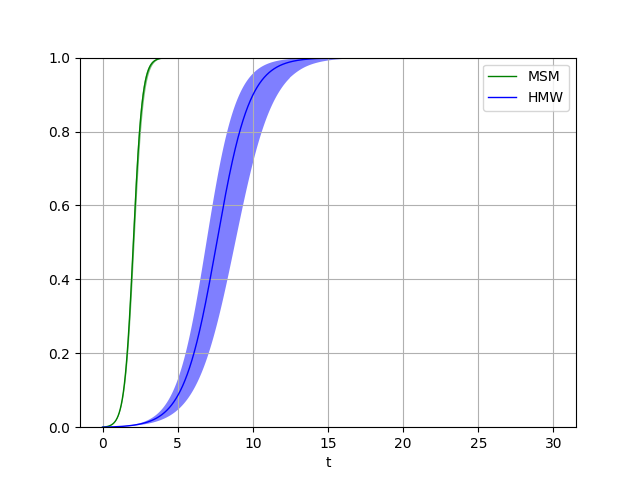

In [8]:
plt.figure()
ratio_sol_msm = (sol_msm[:,:, 2] + sol_msm[:,:, 3])/(sol_msm[:,:, 2] + sol_msm[:,:, 3] + sol_msm[:,:, 4] + sol_msm[:,:, 5])
plt.plot(t, ratio_sol_msm[1,:], label = "MSM", c = "g",linewidth=1)
plt.fill_between(t,ratio_sol_msm[0,:], ratio_sol_msm[2,:], alpha=0.5, facecolor = "g")
ratio_sol_hmw = (sol_hmw[:,:, 2] + sol_hmw[:,:, 3])/(sol_hmw[:,:, 2] + sol_hmw[:,:, 3] + sol_hmw[:,:, 4] + sol_hmw[:,:, 5])
plt.plot(t, ratio_sol_hmw[1,:], label = "HMW", c = "b",linewidth=1)
plt.fill_between(t,ratio_sol_hmw[0,:], ratio_sol_hmw[2,:], alpha=0.5, facecolor = "b")
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.ylim(0,1)
plt.show()

# Simple Contact network

## Build a network

In [6]:
# # create power law graph
# exp = 2.4
# seed = 123456789
# num = 1000
# graph = power_law_graph(exp, num, seed)

# or, create random network
p = 0.1
num = 100
seed = 1234
graph = random_network(p, num, seed)

# compute average degree
degrees = dict(graph.degree())
sum_of_edges = sum(degrees.values())
average_deg = sum_of_edges / len(degrees)
print(average_deg)

# compute r0 (TODO)

9.78


<IPython.core.display.Javascript object>


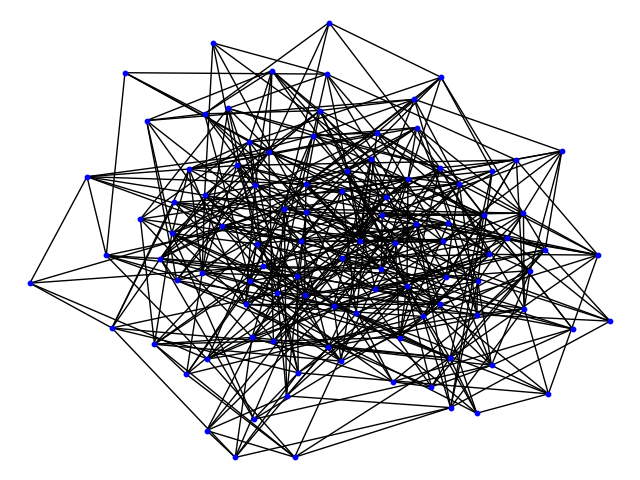

In [7]:
plt.figure()
pos = nx.spring_layout(graph)
nx.draw(graph, pos, node_color='b', node_size=10, with_labels=False)
plt.show()

## Implementation of disease spreading

In [ ]:
# set person class to each node
for i in range(len(graph)):
    graph.node[i]["Data"] = Individual(i)

# create set of infecteds, initialize with 10 infecteds
init = np.random.choice(len(graph), 10, replace=False)

# time steps
t = 0
t_tot = 20
time_step = 365
dt = 1 / (time_step)

# constants of model
D = 0.19 * time_step
mu = 1e-3
PHI = [0.65, 0.50]
BETA = [0.59, 0.87]

# keep track of infecteds and steps
num_steps = int(t_tot / dt)
num_infected = np.zeros((2, num_steps))
num_res = np.zeros((2, num_steps))

# iterate over sextypes (MSM and HMW)
for sextype in range(2):
    phi = PHI[sextype]
    beta = BETA[sextype]
    beta = 1 - (1 - beta)**(1 / time_step)
    nu = 2e-3 * (1 - phi)
    tau = 8e-3 * phi
    num_res[sextype,:], num_infected[sextype,:], graph = network_model(beta, tau, nu, mu, init, num_steps, copy.deepcopy(graph), True)

## Plotting

In [ ]:
# plot number of infecteds
t = np.linspace(0,t_tot, num_steps)    
plt.figure()
print("Mean number of infecteds:", np.mean(num_infected))
plt.plot(t, num_infected[0,:], label='all infecteds MSM')
plt.plot(t, num_res[0,:], label='resistant infecteds MSM')
plt.plot(t, num_infected[1,:], label='all infecteds HMW')
plt.xlabel("Time (years)")
plt.plot(t, num_res[1,:], label='resistant infecteds HMW')
plt.legend()
plt.show()

plt.figure()
plt.plot(t,num_res[0,:]/num_infected[0,:], label='fraction of resistant strain MSM')
plt.plot(t,num_res[1,:]/num_infected[1,:], label='fraction of resistant strain HMW')
# plt.plot(num_res)
plt.xlabel("Time (years)")
plt.legend()
plt.show()

## Plots for different beta (TODO)

In [ ]:
# set person class to each node
for i in range(len(graph)):
    graph.node[i]["Data"] = Individual(i)

# create set of infecteds, initialize with 10 infecteds

init = np.random.choice(len(graph), 10, replace=False)

t = 0
t_tot = 10
time_step = 365
dt = 1 / (time_step)
D = 0.19 * time_step
mu = 1e-3

# constants of model
PHI = [0.65, 0.50]
BETA = np.linspace(0.15, 0.3, 10)

# keep track of infecteds and steps
num_steps = int(t_tot / dt)
num_infected = np.zeros((len(BETA), num_steps))
num_res = np.zeros((len(BETA), num_steps))

for i, beta in enumerate(BETA):
    phi = PHI[0]

    BETA = 1 - (1 - BETA)**(1 / time_step)
    nu = 2e-3 * (1 - phi)
    tau = 8e-3 * phi
    num_res[i,:], num_infected[i,:], graph= network_model(beta, tau, nu,mu, init, num_steps, copy.deepcopy(graph))


In [ ]:
t = np.linspace(0,t_tot, num_steps)    
plt.figure()

plt.plot(BETA, num_infected[:,-1], label='all infecteds %i' % BETA[i])
plt.plot(BETA, num_res[:,-1], label='resistant infecteds %i'% BETA[i])
# plt.legend()
plt.show()

# plt.figure()
# plt.plot(t,num_res[0,:]/num_infected[0,:], label='fraction of resistant strain MSM')
# plt.plot(t,num_res[1,:]/num_infected[1,:], label='fraction of resistant strain HMW')
# # plt.plot(num_res)
# plt.legend()
# plt.show()

## Animation

In [ ]:
# set person class to each node
for i in range(len(graph)):
    graph.node[i]["Data"] = Individual(i)

# create set of infecteds, initialize with 10 infecteds
init = np.random.choice(len(graph), 10, replace=False)

# time
t = 0
t_tot = 20
time_step = 365
dt = 1 / (time_step)

# constants of model
D = 0.19 * time_step
mu = 1e-3
PHI = [0.65, 0.50]
BETA = [0.59, 0.87]

# choose MSM or HMW to model
sextype = 0
phi = PHI[sextype]
beta = BETA[sextype]
beta = 1 - (1 - beta)**(1 / time_step)
nu = 2e-3 * (1 - phi)
tau = 8e-3 * phi

# initial state
_, _, graph = network_model(beta, tau, nu, mu, init, 0, graph, doInit=True, disable_progress=True)

# get values of disease status
values = []
for j in range(len(graph.nodes())):
    if graph.node[j]["Data"].disease_status == 0:
        values.append("Black")
    elif graph.node[j]["Data"].disease_status == 1:
        values.append("Blue")
    elif graph.node[j]["Data"].disease_status == 2:
        values.append("Red")
        
# create figure and set axes
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
im1, = ax2.plot([], [], c = 'b', label='all infecteds MSM')
im2, = ax2.plot([], [], c = 'r', label='resistant infecteds MSM')
ax2.legend()
ax2.set_xlim(0,20)
ax2.set_ylim(0,1000)

# initialize
pos = nx.spring_layout(graph) 
plt.close()
ani_step = 183
frames = 40
num_infected = np.zeros(ani_step*frames)
num_res = np.zeros(ani_step*frames)

# update function for animation
def update(i):
    temp_res, temp_infected, _ = network_model(beta, tau, nu, mu, init, ani_step, graph, doInit=False, disable_progress=True)
    num_infected[i*ani_step:(i+1)*ani_step] = temp_infected
    num_res[i*ani_step:(i+1)*ani_step] = temp_res
    t = np.linspace(0,i*ani_step/365, i*ani_step) 
    im1.set_data(t, num_infected[:i*ani_step])
    im2.set_data(t, num_res[:i*ani_step])
    ax1.clear()
    
    # solution at step i
    values = []
    for j in range(len(graph.nodes())):
        if graph.node[j]["Data"].disease_status == 0:
            values.append("Black")
        elif graph.node[j]["Data"].disease_status == 1:
            values.append("Blue")
        elif graph.node[j]["Data"].disease_status == 2:
            values.append("Red")
    nx.draw(graph, pos=pos, node_color=values, node_size=10, ax=ax1, clim = 2)
    
    # Scale plot ax
    ax1.set_title("Frame %d:    "%(i+1), fontweight="bold")
    ax1.set_xticks([])
    ax1.set_yticks([])
    
# animate!
animation.FuncAnimation(fig, update, frames=40, interval=100, repeat=True)

# Stochastic network model

##### M. Kretzschmar et al., Modeling  Prevention  Strategies for  Gonorrhea  and Chlamydia  Using Stochastic  Network  Simulations,  Am  J Epidemiol   1996;144:306-17

The model consists of Persons defined by:
- Gender (male / female)
- Age (15 - 64)
- Sexual activity (high / low)
- Disease status (uninfected or (non-)resistant (a)symptomatic)

A Person may enter a Partnership with another Person in each timestep. A Partnership is defined by:
- Type (casual or steady)
- The two Persons involved
Partnerships are dynamically formed and broken during the simulation. This dynamic component 

Each timestep of the model consists of seven parts:
<ol>
    <li>Partnership formation</li>
    - generate event with specific properties
    <li>Disease transmission</li>
    - for each partnership, transmit disease with some gender-specific probability
    <li>Separation of partnerships</li>
    - for each type of partnership, remove with some probability
    <li>Replacement</li>
    - for all persons aged 65, replace with new person of age 15
    <li>Recovery</li>
    - for all infected persons, recover with some infection-specific probability
    <li>Treatment</li>
    - for all non-resistant symptomatic persons, get treatment after some time since infection
    <li>Advance time</li>
    - increase time for all persons
</ol>

## Initialize model

The model is initialized with 10,000 persons of random age and a male:female ratio of ~1:1. For persons aged < 35 years, the sexual activity is high with 5% probability

We perform 2,000 iterations to obtain the steady state. Then ~10% of the core group (high sexual activity) is infected with the non-resistant asymptomatic disease

Persons with the symptomatic disease will get treatment after the incubation time and some delay time. The treatment will result in contracting the resistant disease with probability 0.01%, otherwise the person is immediately cured and again susceptible

Each timestep of the model consists of seven parts:
<ol>
    <li>Partnership formation</li>
    - generate event with specific properties
    <li>Disease transmission</li>
    - for each partnership, transmit disease with some gender-specific probability
    <li>Separation of partnerships</li>
    - for each type of partnership, remove with some probability
    <li>Replacement</li>
    - for all persons aged 65, replace with new person of age 15
    <li>Recovery</li>
    - for all infected persons, recover with some infection-specific probability
    <li>Treatment</li>
    - for all non-resistant symptomatic persons, get treatment after some time since infection
    <li>Advance time</li>
    - increase time for all persons
</ol>

## Initialize model

The model is initialized with 10,000 persons of random age and a male:female ratio of ~1:1. For persons aged < 35 years, the sexual activity is high with 5% probability

We perform 2,000 iterations to obtain the steady state. Then ~10% of the core group (high sexual activity) is infected with the non-resistant asymptomatic disease

Persons with the symptomatic disease will get treatment after the incubation time and some delay time. The treatment will result in contracting the resistant disease with probability 0.01%, otherwise the person is immediately cured and again susceptible

In [32]:
#initialize System
s = System()
s.set_constants()
s.initialize()

#initialize lists to store counts
singles_list = []
steady_list = []
partnerships_list = []

#start time steps to reach steady state
start = time.time()
for i in range(2000):
    s.time_step()
    singles_list.append(s.number_of_singles)
    steady_list.append(s.number_of_steady)
    partnerships_list.append(len(s.partnerships))

print("TIME TO INITIALIZE MODEL: %.2f"%(time.time() - start))

#print core size (sexual_activity == 1)
core_size = len(s.high_sexual_activity)
print("Core size: %d"%(core_size))

#random infection of the core group
infect = np.random.choice(list(s.high_sexual_activity),int(0.1 * core_size))
for i in infect:
    p = s.persons[i]
    p.asymptomatic_infection(s)

#set System time to zero
s.time = 0

TIME TO INITIALIZE MODEL: 43.16
Core size: 204


### Evolution over time

In the graph, the evolution towards the steady state is shown. For the default parameters, the steady state has ~80% of all persons in a partnership and ~4,000 steady partnerships. At this point, we infect ~10% of the core group

In [ ]:
# #print percentage of singles in the System
# singles = len(s.singles)/len(s.persons) * 100
# print("Percentage of singles: %f"%(singles))

# #print percentage having one partner
# one_partner = 0
# for p in s.persons:
#     if len(p.current_partners) == 1:
#         one_partner += 1
# one = one_partner/len(s.persons) * 100
# print("Percentage having one partner: %f"%(one))
# print("Percentage having more than one partner: %f"%(100 - singles - one))

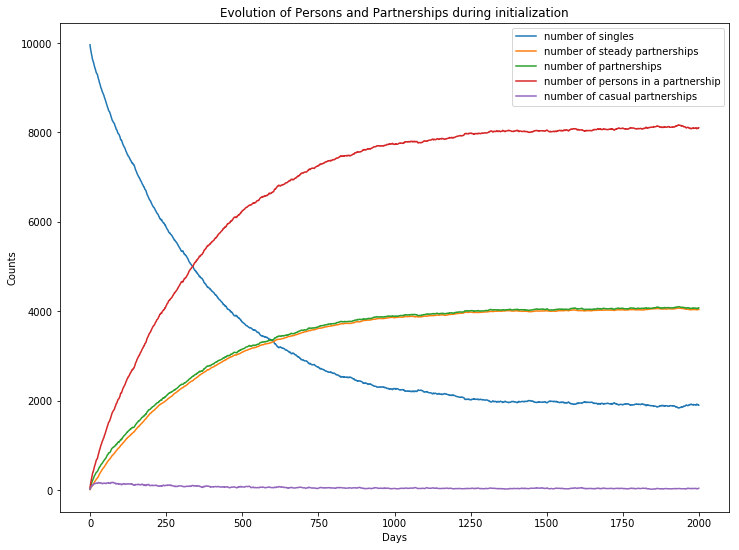

In [34]:
#plot change over time, reaching the steady state
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(singles_list,label="number of singles")
ax.plot(steady_list,label="number of steady partnerships")
ax.plot(partnerships_list,label="number of partnerships")
ax.plot(len(s.persons)-np.array(singles_list),label="number of persons in a partnership")
ax.plot(np.array(partnerships_list) - np.array(steady_list),label="number of casual partnerships")
ax.set_title("Evolution of Persons and Partnerships during initialization")
ax.set_xlabel("Days")
ax.set_ylabel("Counts")
ax.legend();

### Evolve system over time

In [35]:
#initialize lists
singles_list = [s.number_of_singles]
steady_list = [s.number_of_steady]
partnerships_list = [len(s.partnerships)]
symptomatic_list = [s.number_of_symptomatic]
asymptomatic_list = [s.number_of_asymptomatic]
res_symp_list = [s.number_of_res_symp]
res_asymp_list = [s.number_of_res_asymp]

#store starting time
start = time.time()

for i in range(12000):
    #make a single time step
    s.time_step()
    
    #append new values to lists
    singles_list.append(s.number_of_singles)
    steady_list.append(s.number_of_steady)
    partnerships_list.append(len(s.partnerships))
    symptomatic_list.append(s.number_of_symptomatic)
    asymptomatic_list.append(s.number_of_asymptomatic)
    res_symp_list.append(s.number_of_res_symp)
    res_asymp_list.append(s.number_of_res_asymp)

#print evaluation time
print(time.time() - start)

213.90961027145386


### Evolution of the population over time

The number of singles and partnerships remain in the same steady state (with some fluctuations around its mean), even when the infection starts to spread

In [ ]:
#show change in counts over time
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(singles_list,label="number of singles")
ax.plot(steady_list,label="number of steady partnerships")
ax.plot(partnerships_list,label="number of partnerships")
ax.plot(len(s.persons)-np.array(singles_list),label="number of persons in a partnership")
ax.plot(np.array(partnerships_list) - np.array(steady_list),label="number of casual partnerships")
ax.set_title("Evolution of the system over time")
ax.set_xlabel("Time in days")
ax.set_ylabel("Counts")
ax.legend();

### Evolution of infections over time

At the start, a steady state (with some deviations around the mean) is quickly reached by the non-resistant disease. When the resistant disease appear, it quickly spreads, thereby reducing the number of non-resistant infections. Another steady state is eventually reached for the number of resistant infections

In [ ]:
#show change in infecteds over time
fig,ax = plt.subplots(figsize=(12,9))
ax.plot(symptomatic_list,label="symptomatically infected")
ax.plot(asymptomatic_list,label="asymptomatically infected")
ax.plot(res_symp_list,label="resistant symptomatically infected")
ax.plot(res_asymp_list,label="resistant asymptomatically infected")
ax.set_title("Evolution of infections over time")
ax.set_xlabel("Time in days")
ax.set_ylabel("Counts")
ax.legend();

### Infectiousness of the disease ($R_0$)

Although the disease might seem quite infectious, simulations have shown $R_0=0.90 \pm 2.93$ (N=1,000, 95% CI). The spread of the disease is very dependent on where the disease is started. If a person with high sexual activity is infected, it will quickly spread throughout this core group whereas a person with low sexual activity may only affect its (single) partner

### Fraction of resistant infections over all infections over time

The fraction of resistant infections shows a sigmoid-like increase over time. At first, only the non-resistant disease exists in the system, but once the resistant disease appears it will quickly become dominant.

In [ ]:
#show change in resistant infections over time
res_inf = np.array(res_symp_list) + np.array(res_asymp_list)
inf = res_inf + np.array(symptomatic_list) + np.array(asymptomatic_list)
fig,ax = plt.subplots(figsize=(12,9))
ax.plot(res_inf/inf)
ax.set_title("Fraction of resistant infections over all infections over time")
ax.set_xlabel("Time in days")
ax.set_ylabel("Fraction of resistant infections");

### Animation

This shows another simulation of the system. Only the core group (high sexual activity) and their partners are shown. As this group has most connections, the spread of the disease will be large here.

When the resistant disease enters the system, the non-resistant disease will leave in just a few years.

In [ ]:
%%capture
#initialize System
s = System()
s.set_constants()
s.initialize()

#evolve to steady state
for i in range(2000):
    s.time_step()
    
#random infection of the core group
infect = np.random.choice(list(s.high_sexual_activity),int(0.1 * core_size))
for i in infect:
    p = s.persons[i]
    p.asymptomatic_infection(s)

#dictionary mapping disease_status to a color
color_dict = {0:'black',1:'blue',2:'green',3:'red',4:'orange'}
dis_dict = {0:'Uninfected',1:'Non-resistant symptomatic',
            2:'Non-resistant asymptomatic',3:'Resistant symptomatic',
            4:'Resistant asymptomatic'}

def plot_graph(i):
    """
    Draw graph for a single time step
    """
    global s,pos,ax
    s.time_step()
    if i % 365 == 0:
        persons = set()
        edges_list = []
        for identifier in s.high_sexual_activity:
            p = s.persons[identifier]
            for partner in p.current_partners:
                persons.add(partner)
                persons.add(identifier)
                edges_list.append((identifier,partner))
        persons_list = sorted(list(persons))
        
        sizes = []
        disease = []
        for identifier in persons_list:
            disease.append(color_dict[s.persons[identifier].disease_status])
            sizes.append(15+30*s.persons[identifier].sexual_activity)

        ax.clear()
        G = nx.Graph()
        G.add_nodes_from(persons_list)
        G.add_edges_from(edges_list)
        nx.draw(G,node_color=disease,node_size=sizes,ax=ax)
        handles = []
        for index in range(5):
            handles.append(mlines.Line2D([],[],color=color_dict[index],marker='o',linestyle='None',
                                        markersize=10,label=dis_dict[index]))
        ax.legend(handles=handles,loc='upper left')
        ax.set_title("Core group and their partners\nT = %d days"%i)

fig,ax = plt.subplots(figsize=(12,9))
anim = animation.FuncAnimation(fig,plot_graph,frames=12020,interval=3,repeat=False)

In [ ]:
anim

# Determine $R_0$

In [ ]:
#import to perform in parallel
from joblib import Parallel, delayed

# todo:
#     - possibility to choose high / low sexual activity?
#     - more verbose from model (x infected y)?
#     - check (a)symptomatic case?

#Note that R0 is very high, due to treatment. If Person A is asymptomatic and has a Partnership with Person B,
#who contracts the symptomatic disease, Person B gets treatment. Person A is however still infectious, so Person
#B will almost immediately contract the disease again. To 'solve' this, we convert the list of Person identifiers
#to a set, such that infections are counted uniquely per Person.

def get_R0():
    """
    Gets a single sample of R0 from the System    
    """
    #initialize System
    s = System()
    s.set_constants(r0=True)
    s.initialize()

    #evolve to steady state
    for j in range(1000):
        s.time_step()
    
    #infect Person 0
    s.persons[0].asymptomatic_infection(s)
    
    #loop until Person 0 is cured
    while not s.persons[0].disease_status == 0:
        s.time_step()
    
    #return R0
    return s.r0_infected

#perform 4 jobs in parallel
a = Parallel(n_jobs=4,verbose=5)(delayed(get_R0)() for i in range(1000))

#convert lists to sets, such that we only have the unique Persons infected
a = [len(set(x)) for x in a]

#print R0 with 95% CI
print(a)
print("R_0 = %f +/- %f"%(np.mean(a),1.96*np.std(a)))